In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import copy
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

from sklearn import tree, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
# %matplotlib inline
%matplotlib qt

In [4]:
from lutils.fin.data_loader import load

In [11]:
def prepare_data(df):
    
    between_times = [['09:00', '10:15'], ['10:30', '11:30'], ['13:30', '15:00'], ['21:00', '23:00']]
    start_ix = 900
    next_tick_sec = 300
    
    def _prepare_data(x, window_size):
        # perform windowing
        n_row = x.shape[0] - window_size + 1
        output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0],x.strides[0]))
#         return output[:-1], output[-1]
        return output
    
    dfs_x = []
    dfs_y = []
    for d in tqdm.tqdm(np.unique(df.index.date)):
        day1S_df = df[df.index.date == d].resample('1S').last()
        day1S_df = day1S_df.interpolate()
        for (start, end) in between_times:
            # X
            _df = day1S_df.between_time(start, end)
            
            if _df.shape[0] > 0:
                ix = _df.index.values
                
                df_x = _prepare_data(_df.last_price.values, start_ix) # len - 900 + 1
                df_y = np.roll(df_x, -start_ix, axis=0)[:-start_ix,:next_tick_sec] # len - 900 + 1 - 900
                
                df_x = df_x - df_x.mean(axis=1, keepdims=True)
                
#                 y = (df_y[:, 0] - df_y[:, -1]) / (df_y.max(axis=1) - df_y.min(axis=1))
                df_y = (df_y[:, -1] - df_y[:, 0]) / df_y[:, 0]
        
                df_y[np.isinf(df_y) | np.isneginf(df_y)] = 0
                df_y[np.isnan(df_y)] = 0
    #             y[df_y[:, 0] > df_y[:, -1]] = y[df_y[:, 0] > df_y[:, -1]] * -1
    #             if y.sum() > 0 and np.abs(y.mean()) != 1:
                
                df_x = pd.DataFrame(df_x, index=ix[:-start_ix+1])
                df_y = pd.DataFrame(df_y, index=np.roll(ix, -start_ix)[:-start_ix-start_ix+1])
                
                dfs_x.append(df_x.iloc[:-start_ix])
                dfs_y.append(df_y)
#                 last_prices.append(_df.last_price)
            
    return dfs_x, dfs_y

In [6]:
df = load('SHFE', 'rb2305')

load Z:/tq_data/ticks\SHFE.rb2305.h5
load Y:/fin_data\2023-05-04\SHFE.rb2305.h5
load Y:/fin_data\2023-05-05\SHFE.rb2305.h5
load Y:/fin_data\2023-05-08\SHFE.rb2305.h5
load Y:/fin_data\2023-05-09\SHFE.rb2305.h5
load Y:/fin_data\2023-05-10\SHFE.rb2305.h5
load Y:/fin_data\2023-05-11\SHFE.rb2305.h5
load Y:/fin_data\2023-05-12\SHFE.rb2305.h5
load Y:/fin_data\2023-05-15\SHFE.rb2305.h5


In [7]:
start_date = '2023-03-15' # '2022-09-01'
end_date = '2023-05-06'

In [8]:
df.index = df.datetime

In [9]:
df = df[start_date:end_date][['last_price', 'volume', 'amount']]

In [12]:
dfs_x, dfs_y = prepare_data(df)

100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.10it/s]


In [11]:
# dfs_x

In [12]:
# dfs_y

In [31]:
len(dfs_x)

134

In [14]:
# with open('dfs.npy', 'wb') as f:
#     np.save(f, dfs_x)
#     np.save(f, dfs_y)

In [15]:
# with open('dfs.npy', 'rb') as f:
#     dfs_x = np.load(f)
#     dfs_x = np.load(f)

In [16]:
# dfs_x[-4].shape

In [17]:
# dfs_x

In [18]:
# dfs_x[-1].shape

In [19]:
# dfs_y[0].shape

In [19]:
end_ix = 120

In [21]:
# del df

In [14]:
import gc

In [15]:
gc.collect()

338

In [ ]:
# X = normalize(np.vstack(dfs_x[-end_ix:]), norm='l2', axis=1)
# y = np.hstack(dfs_y[-end_ix:])

# X = normalize(np.vstack(dfs_x[-end_ix:]))
# y = np.hstack(dfs_y[-end_ix:])



In [30]:
dfs_x[0].head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
2023-03-15 09:00:00,2.602222,0.602222,3.602222,3.602222,2.602222,1.602222,0.602222,1.602222,1.602222,1.602222,...,-2.397778,-2.397778,-2.397778,-1.397778,-1.397778,-1.397778,-1.397778,-1.397778,-1.397778,-1.397778
2023-03-15 09:00:01,0.606667,3.606667,3.606667,2.606667,1.606667,0.606667,1.606667,1.606667,1.606667,1.606667,...,-2.393333,-2.393333,-1.393333,-1.393333,-1.393333,-1.393333,-1.393333,-1.393333,-1.393333,-1.393333
2023-03-15 09:00:02,3.610000,3.610000,2.610000,1.610000,0.610000,1.610000,1.610000,1.610000,1.610000,0.610000,...,-2.390000,-1.390000,-1.390000,-1.390000,-1.390000,-1.390000,-1.390000,-1.390000,-1.390000,-2.390000
2023-03-15 09:00:03,3.615556,2.615556,1.615556,0.615556,1.615556,1.615556,1.615556,1.615556,0.615556,1.615556,...,-1.384444,-1.384444,-1.384444,-1.384444,-1.384444,-1.384444,-1.384444,-1.384444,-2.384444,-1.384444
2023-03-15 09:00:04,2.622222,1.622222,0.622222,1.622222,1.622222,1.622222,1.622222,0.622222,1.622222,1.622222,...,-1.377778,-1.377778,-1.377778,-1.377778,-1.377778,-1.377778,-1.377778,-2.377778,-1.377778,-2.377778


In [29]:
dfs_y[0].head()

,0
2023-03-15 09:15:00,0.001830
2023-03-15 09:15:01,0.001831
2023-03-15 09:15:02,0.001601
2023-03-15 09:15:03,0.002059
2023-03-15 09:15:04,0.002060


In [30]:
# sn.displot(x1[:50], kde=True)

In [31]:
writer = SummaryWriter('runs/log')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32, device=0)
y_train = torch.tensor(y_train, dtype=torch.float32, device=0).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=0)
y_test = torch.tensor(y_test, dtype=torch.float32, device=0).reshape(-1, 1)

In [33]:
n_epochs = 40 #100   # number of epochs to run
batch_size = 10  # size of each batch
total_size = X_train.shape[0]
batch_start = torch.arange(0, total_size, batch_size)
batch_test_start = torch.arange(0, len(X_test), batch_size)

In [34]:
# X

In [42]:
# X_train[:]

In [43]:
class FutureTrendModule(nn.Module):
    def __init__(self):
        super(FutureTrendModule, self).__init__()
        
        # input batch_size 300
        self.fc1 = nn.Sequential(
            nn.Linear(900, 128),
        )
        
        # input batch_size 1 128
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 64 64
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 32 32
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(True),
            nn.AvgPool1d(3, 2),
        )
        
        # input batch_size 256
        self.output_fc1 = nn.Linear(256, 128)
        # input batch_size 128
        self.output_fc2 = nn.Linear(128, 1)

    def forward(self, x):
#         return self.model(x)
        fc1 = self.fc1(x)
        fc1 = fc1.view(-1, 1, 128)
        conv1 = self.conv1(fc1)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        outs = conv3.view(-1, 256)
        out_fc1 = self.output_fc1(outs)
        outs = self.output_fc2(out_fc1)
        return outs, fc1, conv1, conv2, conv3, out_fc1
    

In [51]:
model = FutureTrendModule().to(0)

In [52]:
loss_fn = nn.MSELoss().to(0)  # mean square error
# loss_fn = nn.SmoothL1Loss().to(0)
# loss_fn = nn.CrossEntropyLoss().to(0)
optimizer = optim.Adam(model.parameters(), lr=0.000001)
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum=0.09)

In [53]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    
    running_loss = 0.0
    for i, start in enumerate(batch_start, 1):
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred, fc1, conv1, conv2, conv3, out_fc1 = model(X_batch) # .reshape(-1, 1, 300)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        
        running_loss += loss.item() * X_batch.shape[0]
        
        step = epoch * len(batch_start) + i
        writer.add_scalar('loss', loss.item(), step)
        
#         writer.add_histogram('fc/fc1', torchvision.utils.make_grid(fc1).data.cpu(), step)
#         writer.add_histogram('conv/conv1', torchvision.utils.make_grid(conv1).data.cpu(), step)
#         writer.add_histogram('conv/conv2', torchvision.utils.make_grid(conv2).data.cpu(), step)
#         writer.add_histogram('conv/conv3', torchvision.utils.make_grid(conv3).data.cpu(), step)
        # add_histogram
        
        if i % 5000 == 0:
            writer.add_histogram('deep/01_x', torchvision.utils.make_grid(X_batch).data.cpu(), step)
            
            writer.add_histogram('deep/02_fc1', torchvision.utils.make_grid(fc1).data.cpu(), step)
            writer.add_histogram('deep/03_conv1', torchvision.utils.make_grid(conv1).data.cpu(), step)
            writer.add_histogram('deep/04_conv2', torchvision.utils.make_grid(conv2).data.cpu(), step)
            writer.add_histogram('deep/05_conv3', torchvision.utils.make_grid(conv3).data.cpu(), step)
            writer.add_histogram('deep/06_out_fc1', torchvision.utils.make_grid(conv3).data.cpu(), step)
            
            writer.add_histogram('deep/09_pred', torchvision.utils.make_grid(y_pred).data.cpu(), step)
            
            print('Epoch: [{}/{}], [{}/{}], Loss: {:.8f}'.format(epoch + 1, n_epochs, start+10, total_size, running_loss / (X_batch.shape[0] * i)))
            
    # evaluate accuracy at end of each epoch
    model.eval()
    eval_loss = 0.0
    for i, start in enumerate(batch_test_start, 1):
        X_batch_test = X_test[start:start+batch_size]
        y_batch_test = y_test[start:start+batch_size]
        
        y_pred, fc1, conv1, conv2, conv3, out_fc1 = model(X_batch_test)
        loss = loss_fn(y_pred, y_batch_test).cpu().detach().numpy()
        
        eval_loss += loss.item() * X_batch_test.shape[0]
    
    eval_loss = eval_loss / X_test.shape[0]
    print('eval loss {:.8f}'.format(eval_loss))
    history.append(eval_loss)
    if eval_loss < best_mse:
        best_mse = eval_loss
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: [1/40], [50000/332787], Loss: 0.000027
Epoch: [1/40], [100000/332787], Loss: 0.000014
Epoch: [1/40], [150000/332787], Loss: 0.000009
Epoch: [1/40], [200000/332787], Loss: 0.000007
Epoch: [1/40], [250000/332787], Loss: 0.000006
Epoch: [1/40], [300000/332787], Loss: 0.000005
eval loss 0.000001
Epoch: [2/40], [50000/332787], Loss: 0.000000
Epoch: [2/40], [100000/332787], Loss: 0.000000
Epoch: [2/40], [150000/332787], Loss: 0.000000
Epoch: [2/40], [200000/332787], Loss: 0.000000
Epoch: [2/40], [250000/332787], Loss: 0.000000
Epoch: [2/40], [300000/332787], Loss: 0.000000
eval loss 0.000001
Epoch: [3/40], [50000/332787], Loss: 0.000000
Epoch: [3/40], [100000/332787], Loss: 0.000000
Epoch: [3/40], [150000/332787], Loss: 0.000000
Epoch: [3/40], [200000/332787], Loss: 0.000000
Epoch: [3/40], [250000/332787], Loss: 0.000000
Epoch: [3/40], [300000/332787], Loss: 0.000000
eval loss 0.000001
Epoch: [4/40], [50000/332787], Loss: 0.000000
Epoch: [4/40], [100000/332787], Loss: 0.000000
Epoch: 

KeyboardInterrupt: 

In [54]:
y_pred

tensor([[-0.0010],
        [-0.0009],
        [-0.0010],
        [-0.0009],
        [-0.0010],
        [-0.0010],
        [-0.0010],
        [-0.0009],
        [-0.0009],
        [-0.0009]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
y_test.max()

tensor(0.0140, device='cuda:0')

In [55]:
torch.save(model.state_dict(), 'model_0603_01.pt')

In [29]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

MSE: 0.14
RMSE: 0.38


In [16]:
np.array(history)

array([0., 0., 0.], dtype=float32)

In [25]:
# price_data = df.close
price_data = df_1T.last_price.diff(1).fillna(0)

<AxesSubplot:xlabel='last_price', ylabel='Count'>

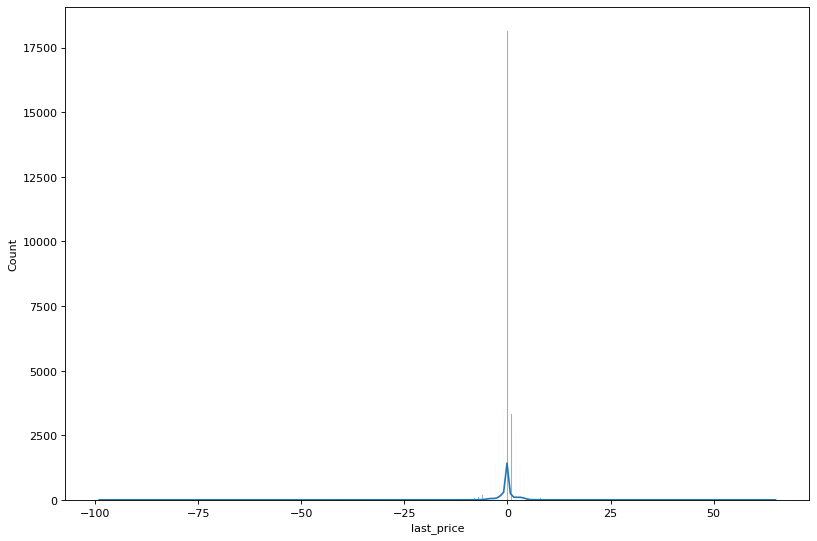

In [27]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
sn.histplot(price_data, kde=True, ax=ax)

In [31]:
config = {
#     "alpha_vantage": {
#         "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
#         "symbol": "IBM",
#         "outputsize": "full",
#         "key_adjusted_close": "5. adjusted close",
#     },
    'symbol': 'rb2305',
    "data": {
        "window_size": 30,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 400,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [32]:
num_data_points = df_1T.shape[0]

In [33]:
data_close_price = price_data.to_numpy()

In [34]:
data_date = df_1T.index.strftime('%Y-%m-%d %H-%M').to_list()
# data_date.reverse()

In [35]:
display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]